In [ ]:
'''!pip3 install numpy
!pip3 install pandas
!pip3 install pyLDAvis
!python3 -m spacy download en
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip -o '/content/mallet-2.0.8.zip'
!pip3 install nltk
!pip3 install openpyxl
!pip3 install gensim
!pip3 install spacy
!pip3 install pyLDAvis
!pip3 install matplotlib
!pip3 install ssl
!pip3 install smart-open==1.10.0
'''

## Import Packets  

In [4]:
import re
import ssl
import numpy as np
import pandas as pd
from pprint import pprint

# NLTK
import nltk
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('popular', quiet=True)

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
pd.set_option('display.max_colwidth',1000)

In [5]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'to', 'all', 'the', 'a', 'an', 'of', 'for', 'with', 'in', 'on', 'at', 'it']) # Can be extended

In [6]:
import pandas as pd
mail_csv = pd.read_csv("vben.csv")
mail_csv.head()

cleared_content
0                                                                                                                                                                                                                               On 27/02/2019, they cut nearly 900 lira in my loan from the Şanlıurfa branch. And although I closed this loan on 25/11/2019, there was a small amount of refund. I want a refund of my unfair deductions. If there is no refund, I will complain to the Consumer Rights.
1                                                                                                                                                                                                                                                               I used a loan from VakıfBank on September 30, 2019. Already 900 TL life insurance premium has been cut. When I checked later, 200 TL lifeguard insurance premium was cut. I want this premium to be canceled and the fee refunded to me.
2  Although I was a customer of salary in the loan process, he collected money called the campaign package that understood me. The services included in this package existed because I am already a salary customer. Also, compulsory insurance was made to me under the name of general health insurance. It was declared that I cannot use credit if I do not have these. After three cents of interest rate cut, you are removing it from the citizens. I demand the return of my money unfairly cut.
3                                                                                                                                                                                   Customer referee Banks Association of Turkey as a result of my application to the Board's fee for the package dbühhh-6.12.2019-20 understands that although the number has been decided to side with the extradition decision. I request the cancellation of the package and the fee received to my current account.
4                                                                                                                                                                                                                                                My complaint, which I applied from your bank and accepted by you with the application number 3448147, has still not been resolved. I request that my request be taken seriously and resolved as soon as possible. I hope you will understand this time.

## Gensim’s inbuilt version of the LDA algorithm

In [7]:
data = mail_csv.sample(n = 256)[['cleared_content']].cleared_content.values.tolist()

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(data))

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])


['despite', 'having', 'my', 'salary', 'he', 'put', 'block', 'on', 'of', 'vakıfbank', 'they', 'did', 'not', 'settle', 'for', 'this', 'they', 'did', 'it', 'and', 'always', 'have', 'my', 'account', 'blocked', 'and', 'that', 'is', 'done', 'at', 'vakıfbank', 'van', 'branch', 'am', 'in', 'izmir', 'cannot', 'go', 'to', 'the', 'main', 'branch', 'van', 'and', 'van', 'and', 'the', 'employee', 'who', 'applies', 'these', 'blocks', 'arbitrarily', 'does', 'not', 'answer', 'the', 'phones']


In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN','ADV','VERB','ADJ']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN','ADV','VERB','ADJ'])

print(data_lemmatized[:1])

[['salary', 'put', 'block', 'vakıfbank', 'settle', 'always', 'account', 'block', 'do', 'branch', 'can', 'go', 'main', 'branch', 'employee', 'apply', 'block', 'arbitrarily', 'answer', 'phone']]


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 3), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]]


In [12]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in text[:20]] for text in corpus[:1]]

[[('account', 1),
  ('always', 1),
  ('answer', 1),
  ('apply', 1),
  ('arbitrarily', 1),
  ('block', 3),
  ('branch', 2),
  ('can', 1),
  ('do', 1),
  ('employee', 1),
  ('go', 1),
  ('main', 1),
  ('phone', 1),
  ('put', 1),
  ('salary', 1),
  ('settle', 1),
  ('vakıfbank', 1)]]

In [13]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=18, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

In [14]:
# Print the 10 Keyword in the semantic topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.081*"customer" + 0.053*"call" + 0.050*"service" + 0.048*"minute" + '
  '0.028*"wait" + 0.027*"vakıfbank" + 0.024*"card" + 0.024*"necessary" + '
  '0.019*"provision" + 0.019*"information"'),
 (1,
  '0.049*"illegal" + 0.047*"policy" + 0.046*"legal" + 0.044*"cancellation" + '
  '0.037*"committee" + 0.032*"refund" + 0.031*"several" + 0.028*"make" + '
  '0.026*"let" + 0.025*"interruption"'),
 (2,
  '0.070*"limit" + 0.045*"decision" + 0.027*"accord" + 0.022*"appear" + '
  '0.021*"business" + 0.019*"can" + 0.019*"automatic" + 0.018*"want" + '
  '0.018*"office" + 0.018*"credit"'),
 (3,
  '0.108*"salary" + 0.065*"cut" + 0.041*"account" + 0.038*"make" + '
  '0.036*"customer" + 0.035*"money" + 0.030*"deduction" + 0.024*"execution" + '
  '0.024*"bank" + 0.023*"vakıfbank"'),
 (4,
  '0.129*"insurance" + 0.082*"refund" + 0.080*"loan" + 0.055*"cut" + '
  '0.051*"name" + 0.043*"make" + 0.038*"collection" + 0.038*"return" + '
  '0.037*"policy" + 0.032*"consumer"'),
 (5,
  '0.049*"cost" + 0.043

In [15]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.671591602980471

Coherence Score:  0.4002322755099577


In [16]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.212409 -0.048460       1        1  19.107264
9     -0.209045 -0.096783       2        1  16.719730
17    -0.201804  0.108198       3        1  13.974730
3     -0.109545  0.130204       4        1   7.151679
14    -0.117641  0.094284       5        1   5.750304
0     -0.139820 -0.108822       6        1   5.509500
4      0.070185  0.263270       7        1   4.678802
2     -0.000012 -0.057522       8        1   4.067908
13     0.094895  0.201521       9        1   3.977755
15    -0.013895 -0.098366      10        1   3.440460
7      0.065328 -0.077618      11        1   2.779170
16     0.031602 -0.107869      12        1   2.606932
10     0.088568 -0.066311      13        1   2.358827
1      0.100732  0.143771      14        1   2.151606
8      0.104005 -0.121152      15        1   1.807889
5      0.170230 -0.001364      16        1   1.745340
11     0.176973 -0.117620      17        1   1.304988
12     0.101654 -0.039361      18        1   0.867118, topic_info=          Term        Freq       Total Category  logprob  loglift
80        card  274.000000  274.000000  Default  30.0000  30.0000
115  insurance   99.000000   99.000000  Default  29.0000  29.0000
113        fee  114.000000  114.000000  Default  28.0000  28.0000
14      salary  114.000000  114.000000  Default  27.0000  27.0000
0      account  145.000000  145.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
80        card    1.043748  274.170471  Topic18  -4.3505  -0.8232
69      credit    0.257892  139.847748  Topic18  -5.7486  -1.5480
144       shop    0.032829    7.586473  Topic18  -7.8098  -0.6951
148       stop    0.032622    4.111639  Topic18  -7.8161  -0.0889
51       month    0.032538   75.656044  Topic18  -7.8187  -3.0038

[860 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
188       2  0.426533   able
188       4  0.284355   able
188      11  0.071089   able
188      14  0.071089   able
188      16  0.071089   able
...     ...       ...    ...
230      16  0.097359  write
573      10  0.897825  wrong
264       9  0.747625    www
187       1  0.673855   year
187       3  0.314466   year

[1160 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 10, 18, 4, 15, 1, 5, 3, 14, 16, 8, 17, 11, 2, 9, 6, 12, 13])

## Mallet Version of LDA Algorithm 

In [17]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
os.environ.update({'MALLET_HOME':r'/content/mallet-2.0.8/'})
mallet_path = 'mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [18]:
# Compute Coherence Score LDA MALLET
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.45759703637511373


In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(str(num_topics)+"-")
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [20]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

2-
8-
14-
20-
26-
32-
38-


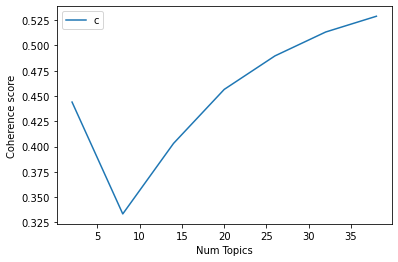

In [21]:
#Choosing the optimal number of LDA topics
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [22]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.444
Num Topics = 8  has Coherence Value of 0.3335
Num Topics = 14  has Coherence Value of 0.4031
Num Topics = 20  has Coherence Value of 0.4566
Num Topics = 26  has Coherence Value of 0.4897
Num Topics = 32  has Coherence Value of 0.5133
Num Topics = 38  has Coherence Value of 0.5289


In [23]:
# Select the highest coherance socred model and print the topics
optimal_model = model_list[np.argmax(coherence_values)]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(3,
  '0.273*"account" + 0.227*"block" + 0.050*"put" + 0.050*"additional" + '
  '0.041*"place" + 0.032*"remove" + 0.032*"brsa" + 0.027*"file" + '
  '0.023*"remain" + 0.023*"enforcement"'),
 (6,
  '0.294*"number" + 0.091*"open" + 0.036*"identity" + 0.036*"question" + '
  '0.030*"hour" + 0.030*"accept" + 0.030*"sms" + 0.025*"register" + '
  '0.025*"update" + 0.025*"warn"'),
 (27,
  '0.194*"phone" + 0.089*"give" + 0.089*"banking" + 0.073*"password" + '
  '0.068*"call" + 0.058*"system" + 0.037*"confirmation" + 0.031*"mother" + '
  '0.026*"nonsense" + 0.021*"permission"'),
 (25,
  '0.151*"information" + 0.134*"make" + 0.117*"amount" + 0.067*"cost" + '
  '0.061*"cash" + 0.056*"mandatory" + 0.056*"withdrawal" + 0.039*"advance" + '
  '0.039*"realize" + 0.028*"request"'),
 (16,
  '0.391*"pay" + 0.238*"debt" + 0.040*"ago" + 0.030*"payment" + 0.030*"mobile" '
  '+ 0.025*"delay" + 0.025*"correct" + 0.020*"lawyer" + 0.015*"trigger" + '
  '0.010*"print"'),
 (17,
  '0.215*"bank" + 0.204*"due" + 0.14

In [24]:
'''# Visualize the topics
pyLDAvis.enable_notebook()
model_vis = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
vis2 = pyLDAvis.gensim.prepare(model_vis, corpus, id2word)
vis2'''

'# Visualize the topics\npyLDAvis.enable_notebook()\nmodel_vis = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)\nvis2 = pyLDAvis.gensim.prepare(model_vis, corpus, id2word)\nvis2'

In [36]:
#Finding the dominant topic in each sentence
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)
print(type(df_dominant_topic))
print(df_dominant_topic['Dominant_Topic'].values[0]) #, " " + df_dominant_topic['Keywords'].values[0] + " " + df_dominant_topic['Text'].values[0])
#print(df_dominant_topic.iat[0,0] + ' ' + df_dominant_topic.iat[0,2] + ' ' + df_dominant_topic.iat[0,3])

<class 'pandas.core.frame.DataFrame'>
3.0


In [39]:
from openpyxl import Workbook, load_workbook
from openpyxl.drawing.image import Image
from openpyxl.utils.dataframe import dataframe_to_rows

# Create new workbook
wb = Workbook()

sheet1 = wb.create_sheet('sheet1',0)

active = wb['sheet1']

# Write dataframe to active worksheet
for x in dataframe_to_rows(df_dominant_topic):
    active.append(x)

# Save workbook to write
wb.save('result.xlsx')

#wb.save(filename)

In [26]:
# Group top 5 sentences under each topic
'''Sometimes just the topic keywords may not be enough to make sense of what a topic is about. 
    So, to help with understanding the topic, you can find the documents a given topic has 
    contributed to the most and infer the topic by reading that document.'''
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)],axis=0)
# Reset Index 
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
# Show
sent_topics_sorteddf_mallet.head()

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.2281   
1        1.0              0.1458   
2        2.0              0.0973   
3        3.0              0.1797   
4        4.0              0.1382   

                                                                                   Keywords  \
0    card, cancel, approximately, force, title, renewal, amount, reply, foundation, address   
1         fee, request, refund, statement, find, regularly, institution, dask, lose, regard   
2          time, work, vakıfbank, complain, long, turn, give, completely, place, constantly   
3           account, block, put, additional, place, remove, brsa, file, remain, enforcement   
4  month, tl, vakıfbank, follow, total, swallow, collection, promise, receivable, calculate   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Text  
0  Approximately 2 months ago, I opened a call for the card renewal process because the credit card I actively used did not see the ATM. The customer service person stated that the card in my hand would be canceled and a new card would be sent, and he said that it would be faster if he was directed to the branch. While the conversation was closed and I checked if the card was canceled, I continued to see that the card was active and continued using it.\n \n\n In the past 2 months, neither a message about the new card nor my current card was used. Until Taki tries to pay off my credit card debt today. My card was confiscated by the ATM. When I called the customer service, my card was canceled; I have learned that a new card has been sent to the branch (I do not know) that the card has been destroyed.\n \n\n I had also applied for a renewal of my card. It turns out that my card was radically canceled and they created a new card for me. Now, to think that that card has not come, and also...  
1                                                                                                                                                                                                                                                                                                                                                                                                                                      I am a user of VakıfBank Worldcard who has been spending regularly and making payments regularly and on time. I am someone who even receives my statement by email. Although the bank I received my salary offers card without subscription fee, I request the refund of my 93 TL card fee, which was withdrawn from my account on 16.08.2017, to my credit card as soon as possible. If my account is checked, it will be seen how regular I am. As a person who spends so much money and pays regularly, I do not find it right to cut this fee and I want it to be returned as soon as possible.  
2                                                                                       I have an import and export company, I have to constantly deposit foreign currency into my foreign currency acco

In [27]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]
# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)
# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']
# Show
df_dominant_topics

Dominant_Topic  \
0.0               3.0   
1.0               7.0   
2.0              28.0   
3.0              28.0   
4.0              27.0   
...               ...   
251.0            16.0   
252.0             7.0   
253.0            18.0   
254.0            19.0   
255.0             1.0   

                                                                                           Topic_Keywords  \
0.0                       account, block, put, additional, place, remove, brsa, file, remain, enforcement   
1.0                money, withdraw, transfer, business, yesterday, require, nonsense, shake, lot, balance   
2.0    package, understand, transaction, collection, cancel, free, content, allocation, require, identify   
3.0    package, understand, transaction, collection, cancel, free, content, allocation, require, identify   
4.0              phone, give, banking, password, call, system, confirmation, mother, nonsense, permission   
...                                                                                                   ...   
251.0                             pay, debt, ago, payment, mobile, delay, correct, lawyer, trigger, print   
252.0              money, withdraw, transfer, business, yesterday, require, nonsense, shake, lot, balance   
253.0            cut, deduction, resolve, civil, repeatedly, interruption, foundation, meet, unable, lady   
254.0                       account, deposit, open, demand, gold, encounter, son, occur, follow, informed   
255.0                   fee, request, refund, statement, find, regularly, institution, dask, lose, regard   

       Num_Documents  Perc_Documents  
0.0              7.0          0.0273  
1.0              7.0          0.0273  
2.0              6.0          0.0234  
3.0              9.0          0.0352  
4.0              6.0          0.0234  
...              ...             ...  
251.0            NaN             NaN  
252.0            NaN             NaN  
253.0            NaN             NaN  
254.0            NaN             NaN  
255.0            NaN             NaN  

[256 rows x 4 columns]